# 计算资源动态分配示例（模型在线服务）

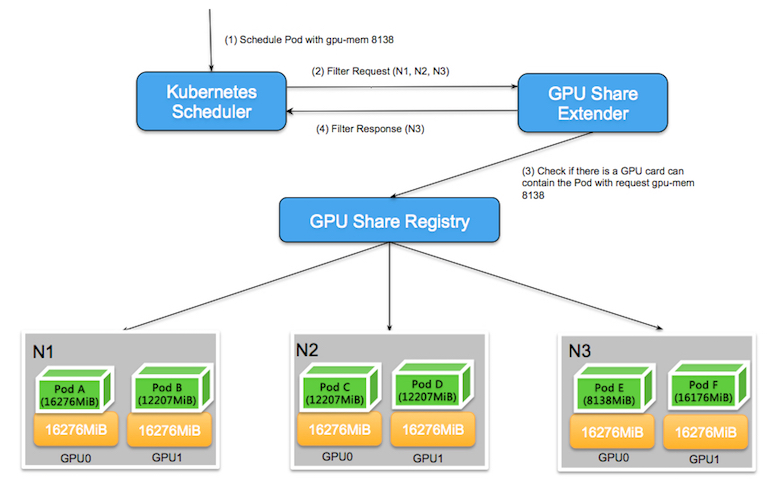

In [1]:
from IPython.display import Image
Image(filename='../../resources/img/aliyun-gpu.png', width=768)

### 初始化SDK与Anylearn后端引擎连接

In [2]:
from anylearn.config import init_sdk
init_sdk('http://192.168.10.22:31888', 'xlearn', '123456')

### 对YOLOv5模型创建20个在线服务，每个服务申请1G显存

*注：集群仅有8张显卡，原有系统仅支持创建至多8个在线服务*

In [3]:
from anylearn.interfaces.resource import Model
from anylearn.interfaces.service import (
    Service, ServiceVisibility, ServiceState,
    ServiceRecord, ServiceRecordState
)

model = next(m for m in Model.get_list() if m.name == "TestAlgoProd25")
for i in range(20):
    service = Service(name=f"DemoServiceGpuShared-{i}",
                      description="DEMO_SDK_GPU_SHARING",
                      model_id=model.id,
                      replicas=1,
                      gpu_mem=1)
    service.save()

import time
time.sleep(120) # 服务启动需一定时间

### 获取服务列表，检查负载状态

In [4]:
services = [s for s in service.get_list() if s.description == "DEMO_SDK_GPU_SHARING"]
for i, s in enumerate(services):
    s_status = s.get_deployment_status()
    available100 = s_status['workers']['replicas'] == s_status['workers']['available_workers']
    print(f"{i}-\t Service[{s.id}]    100% available? {str(available100)}")

0-	 Service[SERVaf6eb9fe11ebba98fee43478d3d2]    100% available? True
1-	 Service[SERV4d2ab9fe11ebba98fee43478d3d2]    100% available? True
2-	 Service[SERV625cb9fe11ebba98fee43478d3d2]    100% available? True
3-	 Service[SERV7f1eb9fe11ebba98fee43478d3d2]    100% available? True
4-	 Service[SERV56bab9fe11ebba98fee43478d3d2]    100% available? True
5-	 Service[SERV69f4b9fe11ebba98fee43478d3d2]    100% available? True
6-	 Service[SERV7f46b9fe11ebba98fee43478d3d2]    100% available? True
7-	 Service[SERV0b44b9fe11ebba98fee43478d3d2]    100% available? True
8-	 Service[SERV4d76b9fe11ebba98fee43478d3d2]    100% available? True
9-	 Service[SERV552eb9fe11ebba98fee43478d3d2]    100% available? True
10-	 Service[SERVc17cb9fe11ebba98fee43478d3d2]    100% available? True
11-	 Service[SERVce1eb9fe11ebba98fee43478d3d2]    100% available? True
12-	 Service[SERVfa28b9fe11ebba98fee43478d3d2]    100% available? True
13-	 Service[SERV4d5cb9fe11ebba98fee43478d3d2]    100% available? True
14-	 Service[SER

### 准备推理测试数据（保养图片）

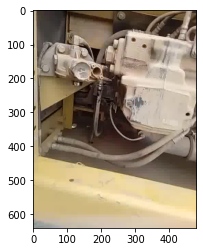

In [5]:
%matplotlib inline

import os

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

test_img_path = "../../resources/img/ty_03_01507.jpg"
img = mpimg.imread(test_img_path)
plt.imshow(img)

### 调用先前创建的20个模型服务的推理接口，检验推理服务是否正常工作

In [6]:
pred_results = []
for s in services:
    with open(test_img_path, "rb") as fb:
        pred_results.append(s.predict_online(file_binary = fb))
for i, r in enumerate(pred_results):
    print(f"{i}-\t Service[{r[1].id}]    worked? {str(not not r[0])}")

0-	 Service[SEREab68b9ff11ebba98fee43478d3d2]    worked? True
1-	 Service[SEREcf68b9ff11ebba98fee43478d3d2]    worked? True
2-	 Service[SEREc096b9ff11ebba98fee43478d3d2]    worked? True
3-	 Service[SEREef1eb9ff11ebba98fee43478d3d2]    worked? True
4-	 Service[SEREa1b6b9ff11ebba98fee43478d3d2]    worked? True
5-	 Service[SERE8710b9ff11ebba98fee43478d3d2]    worked? True
6-	 Service[SERE8bb8b9ff11ebba98fee43478d3d2]    worked? True
7-	 Service[SEREf630b9ff11ebba98fee43478d3d2]    worked? True
8-	 Service[SEREe9cab9ff11ebba98fee43478d3d2]    worked? True
9-	 Service[SEREa858b9ff11ebba98fee43478d3d2]    worked? True
10-	 Service[SERE498cb9ff11ebba98fee43478d3d2]    worked? True
11-	 Service[SEREdd5cb9ff11ebba98fee43478d3d2]    worked? True
12-	 Service[SERE40d4b9ff11ebba98fee43478d3d2]    worked? True
13-	 Service[SERE95ccb9ff11ebba98fee43478d3d2]    worked? True
14-	 Service[SEREc3ecb9ff11ebba98fee43478d3d2]    worked? True
15-	 Service[SERE8186b9ff11ebba98fee43478d3d2]    worked? True
16

### 随机抽取一个推理结果进行展示

In [7]:
H, W = len(img), len(img[0])

import random
results = random.choice(pred_results)[0]
results = [[r[0] * W, r[1] * H, r[2] * W, r[3] * H, r[4], r[5]]
           for r in results if len(r) == 6]
results

[[30.234375, 71.50000095367432, 213.984375, 227.5, 5, 0.9521484375]]

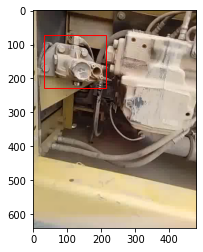

In [8]:
from matplotlib.patches import Rectangle
overlays = [Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], linewidth=1, edgecolor='r', facecolor='none')
            for r in results]
[plt.gca().add_patch(o) for o in overlays]
#[plt.annotate(f"{labels[r[4]]}; {round(r[5], 2)}", (r[0], r[1]), color="r") for r in results]
plt.imshow(img, cmap='gray')

### 清理

In [9]:
print(all([s.delete() for s in services]))

True
